In [77]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)


In [78]:
stock = "INFY"
start_date = "2012-01-01"
end_date = '2021-05-05'
today = '2021-06-16'
lookback = 45

df = web.DataReader(stock,data_source = "yahoo" , start = start_date,end = end_date)
print(df.head())
#dates = df[['Date']].values
df = df[['Close']]

dataset = df.values 
dataset = dataset.astype('float64')
scaler = MinMaxScaler(feature_range = (0,1));
dataset = scaler.fit_transform(dataset)

train_size = (int)(0.8*len(dataset))
train , test = dataset[:train_size,:] , dataset[train_size - lookback:,:]

def to_sequences(dataset,lookback = 15):
    x = []
    y = []
    for i in range(0,len(dataset) - lookback - 1) : 
        window = dataset[i:i + lookback,0]
        x.append(window)
        y.append(dataset[i + lookback,:])
    return np.array(x) , np.array(y)

trainx,trainy = to_sequences(train,lookback)
testx,testy = to_sequences(test,lookback)
print(trainy.shape)

               High      Low     Open    Close      Volume  Adj Close
Date                                                                 
2012-01-03  6.80500  6.66250  6.70625  6.68125  14123200.0   5.280500
2012-01-04  6.75750  6.63875  6.70000  6.65000   9913600.0   5.255803
2012-01-05  6.79375  6.64000  6.65125  6.75125  12347200.0   5.335824
2012-01-06  6.75000  6.64000  6.72625  6.74000  10824000.0   5.326933
2012-01-09  6.93250  6.75250  6.77125  6.91750  16880000.0   5.467220
(1834, 1)


In [79]:
# building the model

model = Sequential()
model.add(Dense(32, input_dim = lookback , activation = 'relu'))
model.add(Dense(16 , activation = 'relu'))

model.add(Dense(1))
# trainy[0].shape = number of days for which we will predict , currently 1

#opt = SGD(learning_rate = 0.1, momentum = 0.9)

model.compile(loss = 'mean_squared_error' , optimizer = 'adam' , metrics = ['acc'])  # try stochastic decend also

print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                1472      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 17        
Total params: 2,017
Trainable params: 2,017
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
history = model.fit(trainx,trainy,validation_data = (testx,testy) , verbose = 1,epochs = 50)

Epoch 1/50
58/58 [==============================] - 1s 6ms/step - loss: 0.0185 - acc: 6.1907e-04 - val_loss: 0.0070 - val_acc: 0.0021
Epoch 2/50
58/58 [==============================] - 0s 2ms/step - loss: 7.3771e-04 - acc: 6.1907e-04 - val_loss: 0.0039 - val_acc: 0.0021
Epoch 3/50
58/58 [==============================] - 0s 3ms/step - loss: 4.3462e-04 - acc: 1.8483e-05 - val_loss: 0.0015 - val_acc: 0.0021
Epoch 4/50
58/58 [==============================] - 0s 2ms/step - loss: 2.6150e-04 - acc: 2.1736e-04 - val_loss: 0.0011 - val_acc: 0.0021
Epoch 5/50
58/58 [==============================] - 0s 2ms/step - loss: 2.3249e-04 - acc: 1.6627e-04 - val_loss: 0.0011 - val_acc: 0.0021
Epoch 6/50
58/58 [==============================] - 0s 2ms/step - loss: 1.8849e-04 - acc: 1.5423e-04 - val_loss: 0.0016 - val_acc: 0.0021
Epoch 7/50
58/58 [==============================] - 0s 2ms/step - loss: 1.9884e-04 - acc: 2.7776e-05 - val_loss: 7.8495e-04 - val_acc: 0.0021
Epoch 8/50
58/58 [================

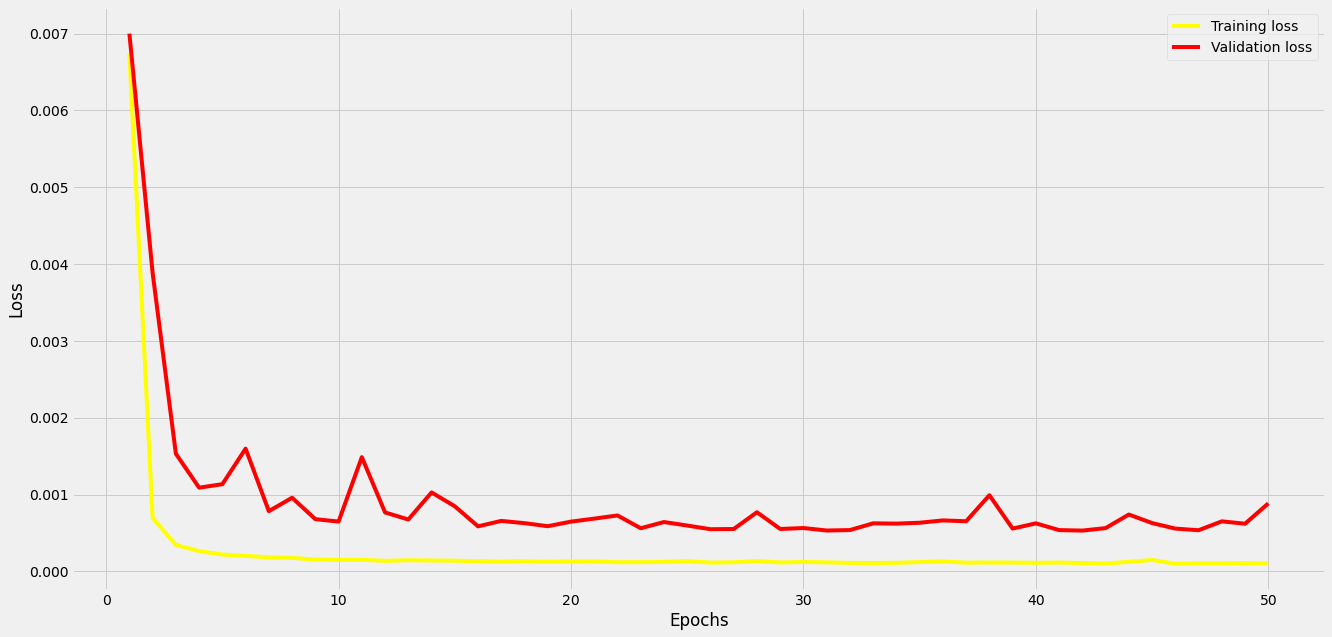

In [81]:
#plotting accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.plot(epochs,loss,'yellow',label = 'Training loss')
plt.plot(epochs,val_loss,'red',label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
trainpredict = scaler.inverse_transform(model.predict(trainx))
testpredict = scaler.inverse_transform(model.predict(testx))
#print(trainpredict)
trueytrain = scaler.inverse_transform(trainy)
trueytest = scaler.inverse_transform(testy)
dataset = scaler.inverse_transform(dataset)

trainScore = math.sqrt(mean_squared_error(trueytrain , trainpredict))
testScore = math.sqrt(mean_squared_error(trueytest , testpredict))
#print(trueytest[:5] ,'\n\n', testpredict[:5])
#print(len(trueytest) ,' ', len(testpredict))
print('Train Score: ',trainScore)
print('Test Score: ',testScore)

Train Score:  0.18937994352482435
Test Score:  0.4395658112234427


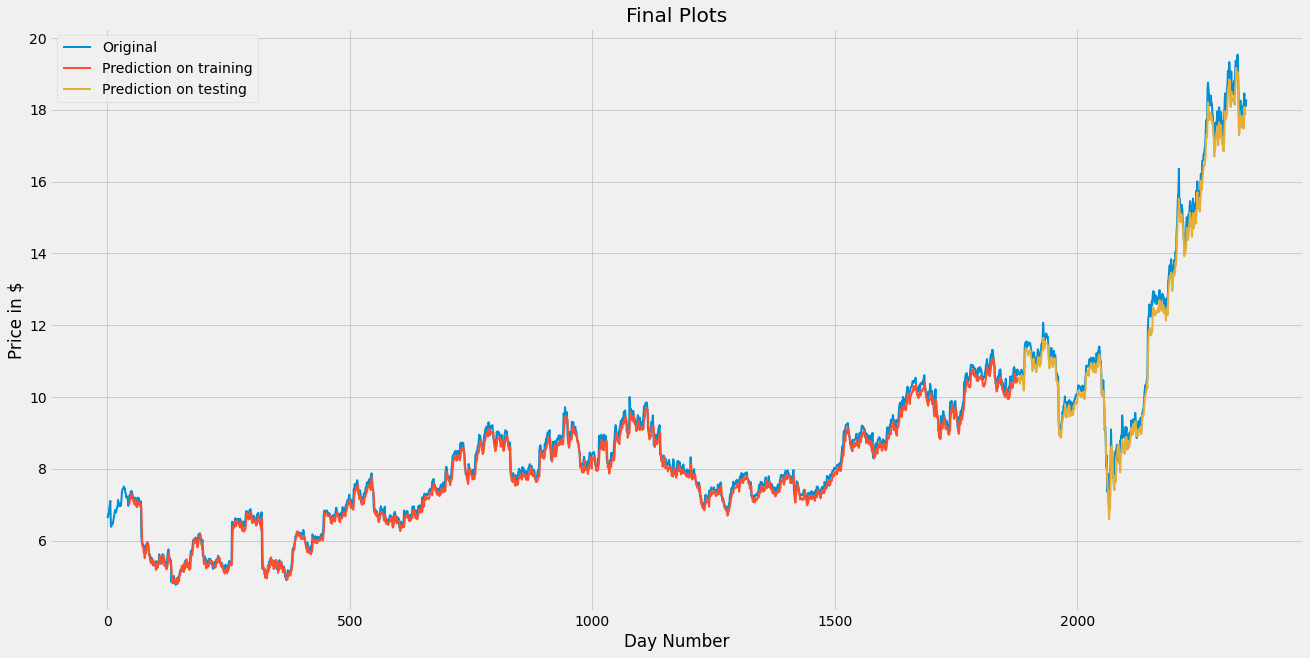

<Figure size 1440x720 with 0 Axes>

In [83]:
# plotting the data
trainpredplot = np.empty_like(dataset)
trainpredplot[:,:] = np.nan
trainpredplot[lookback : lookback + len(trainpredict),:] = trainpredict

testpredplot = np.empty_like(dataset)
testpredplot[:,:] = np.nan
testpredplot[len(trainx) + lookback : len(trainx) + lookback + len(testpredict),:] = testpredict

plt.title('Final Plots')
plt.xlabel('Day Number')
plt.ylabel('Price in $')
plt.plot(dataset, linewidth = 2)
plt.plot(trainpredplot , linewidth = 2)
plt.plot(testpredplot , linewidth = 2)
plt.legend(['Original', 'Prediction on training', 'Prediction on testing'])
plt.figure().figsize = (20,10)
plt.show()

#try scatter plot also

In [84]:
#predicting tomorrow's price

df = web.DataReader(stock,data_source = "yahoo" , start = start_date,end = today)[['Close']]

x = []
x.append(scaler.fit_transform(df.values)[-lookback:,0])
x = np.array(x)

trainpredict = scaler.inverse_transform(model.predict(x))

usdXinr = web.DataReader("INR=X", 'yahoo').iloc[-1]['Close']

print('Tomorrow\'s Price : ',trainpredict[0][0]*usdXinr,' rupees')

Tomorrow's Price :  1462.6999023942626  rupees
